<a href="https://colab.research.google.com/github/romanozamoth/facial-recognition-system-dio/blob/main/Reconhecimento_Facial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [31]:
!pip install tensorflow opencv-python-headless matplotlib


In [ ]:
import cv2
import os
import numpy as np
from mtcnn import MTCNN
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from tensorflow.keras.models import load_model
from google.colab.patches import cv2_imshow  # Para exibir imagens no Colab

In [43]:
from IPython.display import display, Javascript, HTML
from google.colab.output import eval_js
from base64 import b64decode
import time

def auto_capture_photos(duration=10, interval=0.5, filename_prefix='photo'):
    js = Javascript('''
    async function autoCapture(duration, interval, prefix) {
      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(video);
      video.srcObject = stream;
      await video.play();

      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      const photos = [];
      const startTime = Date.now();
      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      const context = canvas.getContext('2d');

      while ((Date.now() - startTime) < duration * 1000) {
        context.drawImage(video, 0, 0);
        photos.push({
          data: canvas.toDataURL('image/jpeg', 0.8),
          time: Date.now()
        });
        await new Promise(resolve => setTimeout(resolve, interval * 1000));
      }

      stream.getVideoTracks()[0].stop();
      video.remove();
      return photos;
    }
    ''')
    display(js)

    # Executa a captura automática
    photos_data = eval_js(f'autoCapture({duration}, {interval}, "{filename_prefix}")')

    # Salva as fotos
    filenames = []
    for i, photo_data in enumerate(photos_data):
        filename = f"{filename_prefix}_{i}.jpg"
        binary = b64decode(photo_data['data'].split(',')[1])
        with open(filename, 'wb') as f:
            f.write(binary)
        filenames.append(filename)

    return filenames

def capture_faces_auto(name, samples=50, interval=1):
    if not os.path.exists(f'dataset/{name}'):
        os.makedirs(f'dataset/{name}')

    detector = MTCNN()
    duration = samples * interval  # Calcula a duração total

    print(f"Iniciando captura automática de {samples} imagens com intervalo de {interval}s...")
    filenames = auto_capture_photos(duration, interval, 'temp_photo')

    count = 0
    for i, filename in enumerate(filenames):
        if count >= samples:
            break

        try:
            image = cv2.imread(filename)
            rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            results = detector.detect_faces(rgb_image)

            if results:
                x, y, w, h = results[0]['box']
                face = rgb_image[y:y+h, x:x+w]
                face = cv2.resize(face, (160, 160))

                cv2.imwrite(f'dataset/{name}/{count}.jpg', cv2.cvtColor(face, cv2.COLOR_RGB2BGR))
                count += 1
                print(f"Face {count}/{samples} capturada")

            os.remove(filename)
        except Exception as e:
            print(f"Erro ao processar {filename}: {str(e)}")
            continue

    print(f"Captura automática concluída! {count} faces válidas capturadas.")

capture_faces_auto("Aline", samples=100, interval=0.5)

Iniciando captura automática de 100 imagens com intervalo de 0.5s...


<IPython.core.display.Javascript object>

Face 1/100 capturada
Face 2/100 capturada
Face 3/100 capturada
Face 4/100 capturada
Face 5/100 capturada
Face 6/100 capturada
Face 7/100 capturada
Face 8/100 capturada
Face 9/100 capturada
Face 10/100 capturada
Face 11/100 capturada
Face 12/100 capturada
Face 13/100 capturada
Face 14/100 capturada
Face 15/100 capturada
Face 16/100 capturada
Face 17/100 capturada
Face 18/100 capturada
Face 19/100 capturada
Face 20/100 capturada
Face 21/100 capturada
Face 22/100 capturada
Face 23/100 capturada
Face 24/100 capturada
Face 25/100 capturada
Face 26/100 capturada
Face 27/100 capturada
Face 28/100 capturada
Face 29/100 capturada
Face 30/100 capturada
Face 31/100 capturada
Face 32/100 capturada
Face 33/100 capturada
Face 34/100 capturada
Face 35/100 capturada
Face 36/100 capturada
Face 37/100 capturada
Face 38/100 capturada
Face 39/100 capturada
Face 40/100 capturada
Face 41/100 capturada
Face 42/100 capturada
Face 43/100 capturada
Face 44/100 capturada
Face 45/100 capturada
Face 46/100 captura

Classes encontradas: ['Aline', 'Yame', 'Thomaz']


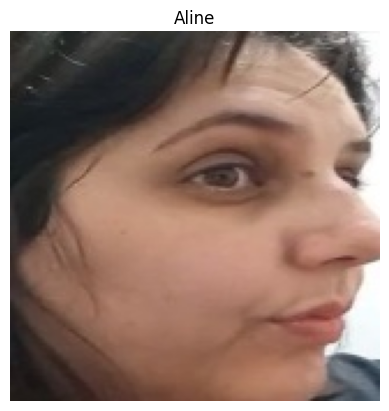

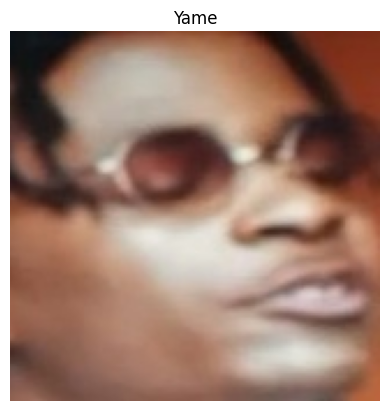

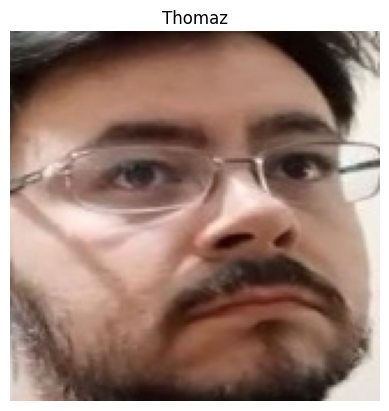

In [48]:
import os
import matplotlib.pyplot as plt
import cv2

base_path = "dataset"
classes=[]
for folder_now in os.listdir(base_path):
  if folder_now != '.ipynb_checkpoints':
    classes.append(folder_now)
print("Classes encontradas:", classes)

# Exibir uma imagem aleatória de cada classe
for label in classes:
    folder = os.path.join(base_path, label)
    file = os.listdir(folder)[0]
    img = cv2.imread(os.path.join(folder, file))
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    plt.title(label)
    plt.axis('off')
    plt.show()


In [61]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models

datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True
)

train_gen = datagen.flow_from_directory(
    'dataset',
    target_size=(100, 100),
    batch_size=16,
    class_mode='categorical',
    subset='training'
)

val_gen = datagen.flow_from_directory(
    'dataset',
    target_size=(100, 100),
    batch_size=16,
    class_mode='categorical',
    subset='validation'
)

model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(100, 100, 3)),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(train_gen.num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(train_gen, validation_data=val_gen, epochs=20)


Found 207 images belonging to 4 classes.
Found 50 images belonging to 4 classes.
Epoch 1/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 159ms/step - accuracy: 0.2904 - loss: 1.6019 - val_accuracy: 0.9000 - val_loss: 0.7990
Epoch 2/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - accuracy: 0.8375 - loss: 0.6473 - val_accuracy: 0.9400 - val_loss: 0.2818
Epoch 3/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.8569 - loss: 0.2946 - val_accuracy: 0.9600 - val_loss: 0.1361
Epoch 4/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - accuracy: 0.9680 - loss: 0.1062 - val_accuracy: 1.0000 - val_loss: 0.0442
Epoch 5/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.9620 - loss: 0.1047 - val_accuracy: 1.0000 - val_loss: 0.0231
Epoch 6/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.9904 - loss: 0.0394 - val_accuracy: 0.9800 - val_loss: 0.0455
Epoch 7/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.9827 - loss: 0.0500 - val_accuracy: 0.9800 - val_loss: 0.0450
Epoch 8/20
13/13 ━━━━━━━━━━━━

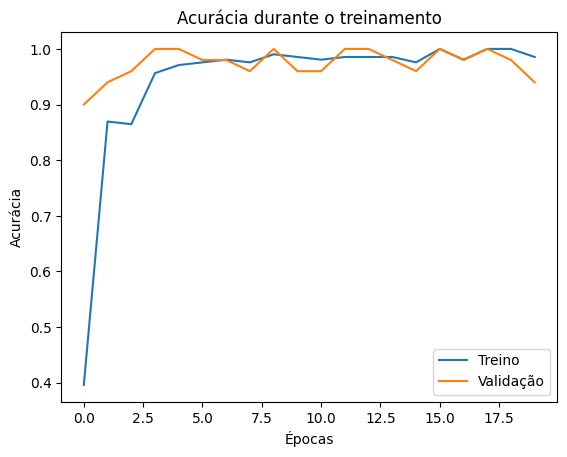

In [62]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Treino')
plt.plot(history.history['val_accuracy'], label='Validação')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.legend()
plt.title('Acurácia durante o treinamento')
plt.show()


In [63]:
def reconhecer_faces(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5)

    for (x, y, w, h) in faces:
        face = img[y:y+h, x:x+w]
        face_resized = cv2.resize(face, (100, 100)) / 255.0
        face_input = face_resized.reshape(1, 100, 100, 3)

        pred = model.predict(face_input)[0]
        label = list(train_gen.class_indices.keys())[pred.argmax()]
        prob = pred.max()

        cv2.rectangle(img, (x, y), (x+w, y+h), (0,255,0), 2)
        cv2.putText(img, f'{label} ({prob:.2f})', (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0,255,0), 2)

    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title("Resultado")
    plt.show()


<IPython.core.display.Javascript object>


Foto capturada com sucesso!


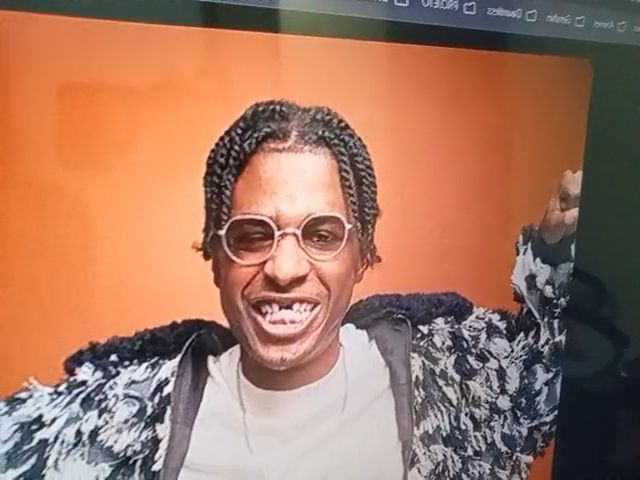

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


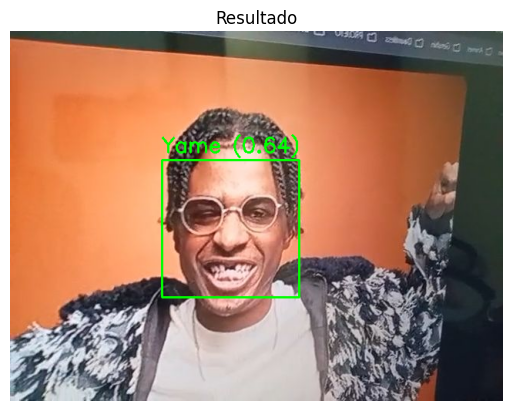

<IPython.core.display.Javascript object>


Foto capturada com sucesso!


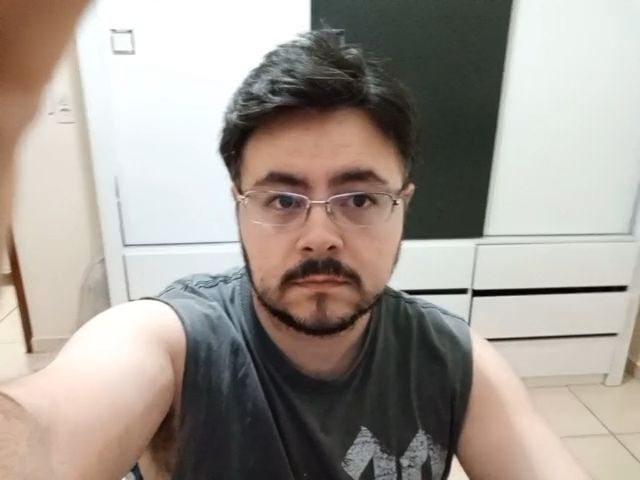

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


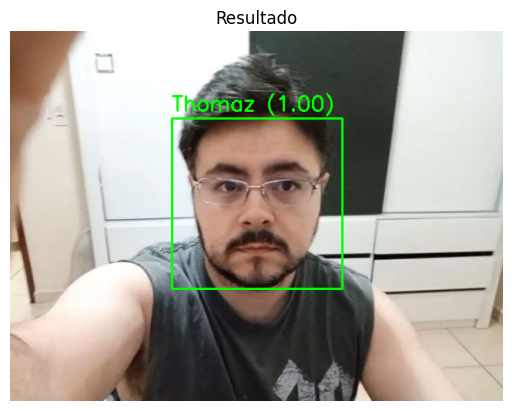

<IPython.core.display.Javascript object>


Foto capturada com sucesso!


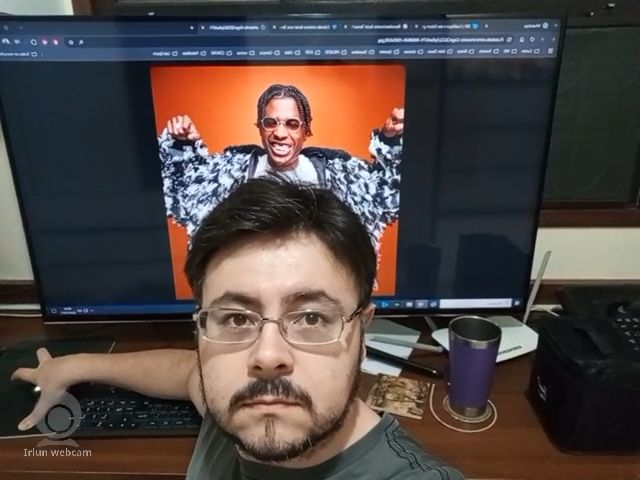

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


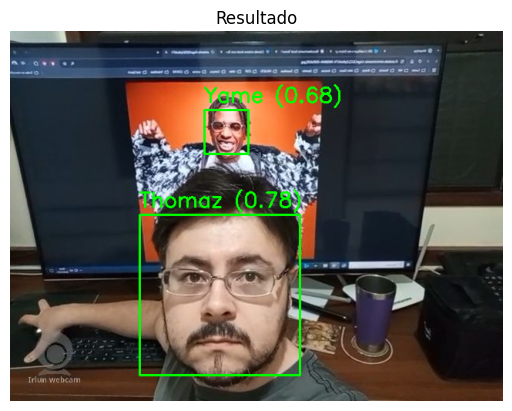

In [69]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
import time

def capture_full_photo(filename='webcam_photo.jpg', quality=0.8):
    """Captura uma foto completa da webcam com botão manual"""

    # JavaScript para criar a interface de captura
    js = Javascript('''
    async function capturePhoto(quality, filename) {
      // Cria elementos da interface
      const div = document.createElement('div');
      const captureBtn = document.createElement('button');
      captureBtn.textContent = 'CAPTURAR FOTO';
      captureBtn.style.cssText = 'padding:10px; font-size:16px; background:#4285F4; color:white; border:none; border-radius:5px;';

      const video = document.createElement('video');
      video.style.display = 'block';
      video.width = 640;
      video.height = 480;

      // Adiciona elementos ao DOM
      div.appendChild(video);
      div.appendChild(document.createElement('br'));
      div.appendChild(captureBtn);
      document.body.appendChild(div);

      // Inicia a webcam
      const stream = await navigator.mediaDevices.getUserMedia({video: true});
      video.srcObject = stream;
      await video.play();

      // Ajusta o iframe do Colab
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Espera pelo clique do botão
      const photoPromise = new Promise((resolve) => {
        captureBtn.onclick = () => {
          const canvas = document.createElement('canvas');
          canvas.width = video.videoWidth;
          canvas.height = video.videoHeight;
          canvas.getContext('2d').drawImage(video, 0, 0);

          stream.getVideoTracks()[0].stop();
          div.remove();
          resolve(canvas.toDataURL('image/jpeg', quality));
        };
      });

      return await photoPromise;
    }
    ''')

    # Exibe o JavaScript
    display(js)

    # Executa a captura
    photo_data = eval_js(f'capturePhoto({quality}, "{filename}")')

    # Decodifica a imagem
    binary = b64decode(photo_data.split(',')[1])
    with open(filename, 'wb') as f:
        f.write(binary)

    # Exibe a foto capturada
    img = cv2.imread(filename)
    print("\nFoto capturada com sucesso!")
    cv2_imshow(img)

    return filename
# TESTE1
photo_path = capture_full_photo('test1.jpg')

reconhecer_faces('test1.jpg')

# TESTE2
photo_path = capture_full_photo('test2.jpg')

reconhecer_faces('test2.jpg')

# TESTE3
photo_path = capture_full_photo('test3.jpg')

reconhecer_faces('test3.jpg')